In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [15]:
pd.to_pickle(train_ins, "test.pkl")


In [18]:
import os


In [ ]:
np.mean([1,3])

In [20]:
os.path.exists('test.pkl')

True

In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
train_ins

array([[-0.10092491, -0.07410525,  0.11087017, ...,  0.27375342,
        -0.90497375, -0.06119799],
       [-0.07410525,  0.11087017,  0.084799  , ..., -0.90497375,
        -0.06119799, -0.06378166],
       [ 0.11087017,  0.084799  , -0.2126321 , ..., -0.06119799,
        -0.06378166, -0.5023462 ],
       ..., 
       [-0.21866465,  0.03518781,  0.59896446, ...,  0.05528065,
        -0.22322908, -0.0416348 ],
       [ 0.03518781,  0.59896446, -0.73175675, ..., -0.22322908,
        -0.0416348 , -0.5487802 ],
       [ 0.59896446, -0.73175675, -0.34503875, ..., -0.0416348 ,
        -0.5487802 , -0.29369081]])

In [5]:
sess = tf.InteractiveSession()

In [6]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3
num_symbols = len(symbol_list)
num_samples = 50

n_input = num_symbols * 100
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_classes = num_positions * num_symbols # MNIST total classes (0-9 digits)


# define placeholders 
x = tf.placeholder(tf.float32, [None, num_symbols * 100])
y_ = tf.placeholder(tf.float32, [None,  num_symbols])

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
y = multilayer_perceptron(x, weights, biases)



# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
sample_n = {}
sample_mask = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(num_symbols):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)
    for sample_iter in range(num_samples):
        sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
        pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
        symbol_returns[i*num_samples + sample_iter] = tf.mul(
                                                            tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                             y_[:,i])
        
        sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
        relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                    symbol_probs * sample_mask[i*num_samples + sample_iter],1)
    


daily_returns_by_symbol_ = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]

total_return = tf.reduce_prod(daily_returns+1, 0)
z = tf.ones_like(total_return) * -1
total_return = tf.add(total_return, z)


ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
    np.sqrt(252)
    )
sharpe = tf.div(total_return, ann_vol)
#Maybe metric slicing later
#segment_ids = tf.ones_like(daily_returns[:,0])
#partial_prod = tf.segment_prod(daily_returns+1, segment_ids)


training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
ones = tf.ones_like(training_target_cols)
gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

#cost = tf.mul(gradient , daily_returns_by_symbol_reshaped)
#cost = tf.mul(gradient , tf.expand_dims(daily_returns, -1))
cost = tf.mul(gradient , tf.expand_dims(total_return, -1))
#cost = tf.mul(gradient , tf.expand_dims(sharpe, -1))

optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
costfn = tf.reduce_mean(cost)

In [7]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(2000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,25)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%100== 0:
        t,s, c = sess.run([ total_return, sharpe, costfn], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        t = np.mean(t)
        s = np.mean(s)
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))
        #print(t)

Epoch: 0100 cost= 23.7673 total return= 0.623627841 sharpe= 1.656383872
Epoch: 0200 cost= 0.401505 total return= 4.365152359 sharpe= 12.998255730
Epoch: 0300 cost= 0.181246 total return= 4.130859852 sharpe= 12.321022034
Epoch: 0400 cost= 0.186346 total return= 4.093906403 sharpe= 12.218827248
Epoch: 0500 cost= 0.189501 total return= 4.093703747 sharpe= 12.202266693
Epoch: 0600 cost= 0.179478 total return= 4.465522289 sharpe= 13.362088203
Epoch: 0700 cost= 0.140895 total return= 4.219608307 sharpe= 12.648667336
Epoch: 0800 cost= 0.0601221 total return= 4.111718655 sharpe= 12.305130959
Epoch: 0900 cost= 0.0561137 total return= 4.037717819 sharpe= 12.109090805
Epoch: 1000 cost= 0.0551769 total return= 4.202248096 sharpe= 12.587093353
Epoch: 1100 cost= 0.0539097 total return= 4.089138031 sharpe= 12.267638206
Epoch: 1200 cost= 0.0591258 total return= 4.095094681 sharpe= 12.276319504
Epoch: 1300 cost= 0.0613771 total return= 3.975343704 sharpe= 11.913067818
Epoch: 1400 cost= 0.0683438 total 

In [8]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([daily_returns, pos[0]], feed_dict={x: train_ins, y_: train_outs})

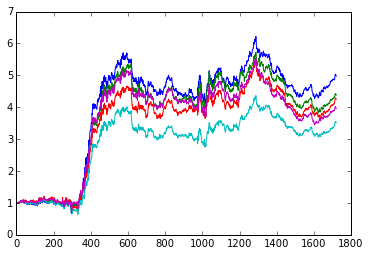

In [9]:
# equity curve
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

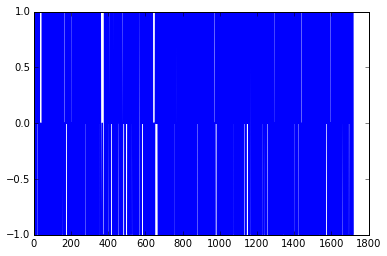

In [10]:
plot(t)

In [11]:
#out of sample results
d, t = sess.run([daily_returns, total_return], feed_dict={x: test_ins, y_: test_outs})

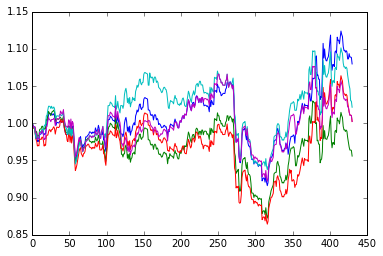

In [12]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))